# Lane Detection Pipeline

In this practice session we will define a special computer vision pipeline. The goal of the pipeline is to detect lane lines in images and videos. Different images are used to check if we worked correctly. The data (videos and images) used in this exercise are based on the course "Self Driving Car Engineer Nanodegree" from Udacity.

This notebook shows you the complete pipeline with the following steps:

1. Load an image
2. Apply Gaussian Blur
3. Perform Canny Edge Detection
4. Define a Region of Interest
5. Retrieve Hough Lines
6. Apply Lane Lines to Images
7. Apply Lane Lines to Videos

---

## Input Video
First, have a look at our input video stream of our front facing dashcam.
(Remove the following cell for the video processing in the last step!)

In [1]:
%%HTML
<video width="960" height="580" controls>
  <source src="./test_videos/solidWhiteRight.mp4" type="video/mp4">
</video>

---

## Import Libraries
In the next step we are adding the necessary python libraries.


In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import plot, show
import numpy as np
from numpy import arange, array, ones, linalg
import math
import cv2
import os
from moviepy.editor import VideoFileClip
import imageio
imageio.plugins.ffmpeg.download()

ModuleNotFoundError: No module named 'cv2'

---

## Important Pipeline Functions
We move all functions for processing the image in one cell.
These functions are called every time we process an image.

In [40]:
def grayscale(img):
    """Applies the grayscale transform
    This will return an image with only one color channel
    But NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from 'vertices'. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by 'vertices' with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are non-zero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    'img' should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines_hough = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines_hough)

    return line_img


def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each
    line and extrapolate to the top and bottom of the lane.

    This function draws 'lines' with 'color' and 'thickness'.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below.
    """
    imshape = img.shape

    vertices = np.array([[(50, imshape[0]), (450, 320), (500, 320), (900, imshape[0])]], dtype=np.int32)
    left_x = []
    left_y = []
    right_x = []
    right_y = []

    left_x1_max = 200
    left_y1_max = imshape[0]
    left_x2_max = 450
    left_y2_max = 320

    right_x1_max = 500
    right_y1_max = 320
    right_x2_max = 870
    right_y2_max = imshape[0]


    for line in lines:
        for x1, y1, x2, y2 in line:

            x_values = float(x2 - x1)
            y_values = float(y2 - y1)
            slope = float(y_values / x_values)
            if slope < 0:
                # Ignore obviously invalid lines
                if slope > -.5 or slope < -.8:
                    continue

                left_x.append(x1)
                left_x.append(x2)
                left_y.append(y1)
                left_y.append(y2)

            else:
                # Ignore obviously invalid lines
                if slope < .5 or slope > .8:
                    continue
                right_x.append(x1)
                right_x.append(x2)
                right_y.append(y1)
                right_y.append(y2)

    right_x.append(right_x1_max)
    right_x.append(right_x2_max)
    right_y.append(right_y1_max)
    right_y.append(right_y2_max)

    left_x.append(left_x1_max)
    left_x.append(left_x2_max)
    left_y.append(left_y1_max)
    left_y.append(left_y2_max)

    x_right = np.asarray(right_x)
    y_right = np.asarray(right_y)
    A_right = array([x_right, ones(len(x_right))])
    w_right = linalg.lstsq(A_right.T, y_right)[0]  # obtaining the parameters
    line_right = w_right[0] * x_right + w_right[1]  # regression line

    x_left = np.asarray(left_x)
    y_left = np.asarray(left_y)
    A_left = array([x_left, ones(len(x_left))])
    w_left = linalg.lstsq(A_left.T, y_left)[0]  # obtaining the parameters
    line_left = w_left[0] * x_left + w_left[1]  # regression line

    x1_right = min(x_right)
    x2_right = int((imshape[0] - w_right[1])/w_right[0])
    y1_right = int(min(line_right))
    y2_right = imshape[0]

    x1_left = int((imshape[0] - w_left[1])/w_left[0])
    x2_left = max(x_left)
    y1_left = imshape[0]
    y2_left = int(min(line_left))


    cv2.line(img, (x1_right,y1_right),(x2_right,y2_right), color, thickness)
    cv2.line(img, (x2_left, y2_left), (x1_left, y1_left), color, thickness)


def weighted_img(img, initial_img, alpha=.8, beta=1., gamma=0.):
    """
    'img' is the output of the hough_lines(): an image with lines drawn on it.
    It should be a blank image (all black) with lines drawn on it.

    'initial_img' should be the image before any processing.

    The result image is computed as follows:

    initial_img * alpha + img * beta + gamma
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)


def draw_lines_test(img, lines, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each
    line and extrapolate to the top and bottom of the lane.

    This function draws 'lines' with 'color' and 'thickness'.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below.
    """
    "Code for the detection from https://github.com/eosrei/CarND-P01-Lane-Lines"
    top = 320
    bottom = 550
    left_x1s = []
    left_y1s = []
    left_x2s = []
    left_y2s = []
    right_x1s = []
    right_y1s = []
    right_x2s = []
    right_y2s = []
    
    for line in lines:
        # print(line)
        # Feel this is the brute force method, but I'm time constrained. I will research ideal numpy methods later.
        for x1, y1, x2, y2 in line:

            x_values = float(x2 - x1)
            y_values = float(y2 - y1)
            slope = float(y_values / x_values)
            if slope < 0:
                # Ignore obviously invalid lines
                if slope > -.5 or slope < -.8:
                    continue
                left_x1s.append(x1)
                left_y1s.append(y1)
                left_x2s.append(x2)
                left_y2s.append(y2)
            else:
                # Ignore obviously invalid lines
                if slope < .5 or slope > .8:
                    continue
                right_x1s.append(x1)
                right_y1s.append(y1)
                right_x2s.append(x2)
                right_y2s.append(y2)

    try:
        avg_right_x1 = int(np.mean(right_x1s))
        avg_right_y1 = int(np.mean(right_y1s))
        avg_right_x2 = int(np.mean(right_x2s))
        avg_right_y2 = int(np.mean(right_y2s))
        right_slope = get_slope(avg_right_x1, avg_right_y1, avg_right_x2, avg_right_y2)

        right_y1 = top
        right_x1 = int(avg_right_x1 + (right_y1 - avg_right_y1) / right_slope)
        right_y2 = bottom
        right_x2 = int(avg_right_x1 + (right_y2 - avg_right_y1) / right_slope)
        cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)
    except ValueError:
        # Don't error when a line cannot be drawn
        pass

    try:
        avg_left_x1 = int(np.mean(left_x1s))
        avg_left_y1 = int(np.mean(left_y1s))
        avg_left_x2 = int(np.mean(left_x2s))
        avg_left_y2 = int(np.mean(left_y2s))
        left_slope = get_slope(avg_left_x1, avg_left_y1, avg_left_x2, avg_left_y2)

        left_y1 = top
        left_x1 = int(avg_left_x1 + (left_y1 - avg_left_y1) / left_slope)
        left_y2 = bottom
        left_x2 = int(avg_left_x1 + (left_y2 - avg_left_y1) / left_slope)
        cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)
    except ValueError:
        # Don't error when a line cannot be drawn
        pass


def get_slope(x1, y1, x2, y2):
    return float(float(y2 - y1) / float(x2 - x1))

---

## Processing an image pipeline
This is the overall function which processes an image step by step with different functions. This function is called every time we process an image.

In [3]:
def process_image(image):

    imshape = image.shape
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, 5)
    canny_blur = canny(blur_gray, 100, 200)
    vertices = np.array([[(50, imshape[0]), (450, 320), (500, 320), (900, imshape[0])]], dtype=np.int32)
    region_masked = region_of_interest(canny_blur, vertices)
    hough_picture = hough_lines(region_masked, 2, np.pi / 180, 20, 50, 30)
    
    #result = canny_blur
    result = weighted_img(hough_picture, image)
    return result
    plt.imshow(gray)
    plt.show()

---

## Find Lane Line in Image
This is the main function which is loading an image, processing an image and applying the detected lane lines to the image. Afterwards, the new image is saved.

Loading an image
Processing an image


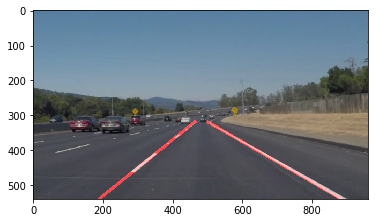

Saving an image 

Loading an image
Processing an image


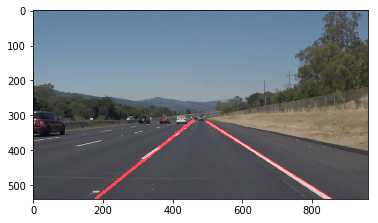

Saving an image 

Loading an image
Processing an image


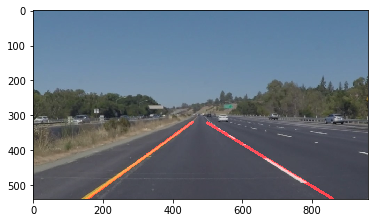

Saving an image 



In [38]:
################        Process for IMAGES        #######################
image = 1
if image == 1:
    images = os.listdir("test_images/")
    for img_file in images:
        print('Loading an image')
        image = mpimg.imread('test_images/' + img_file)
        #plt.imshow(image)
        #plt.show()

        print('Processing an image')
        processed_image = process_image(image)
        plt.imshow(processed_image)
        plt.show()

        plt.imshow(processed_image)
        print('Saving an image \n')
        mpimg.imsave('output_images/lines-' + img_file, processed_image)

---

## Find Lane Line in Video
This is the main function which is loading a video, splitting the video into images, processing an image and applying the found lane lines to the image. Afterwards, a new video is generated from the processed images.

In [46]:
################        Process for Videos       #######################
video = 1
if video == 1:
    print('Loading a video')
    white_output = 'output_videos/output_video.mp4'
    clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
    #clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
    #clip1 = VideoFileClip("test_videos/challenge.mp4")
    a = clip1.fl_image

    print('Processing a video')
    white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

    print('Saving the video')
    white_clip.write_videofile(white_output, audio=False)

Loading a video
Processing a video
Saving the video
[MoviePy] >>>> Building video output_videos/output_video.mp4
[MoviePy] Writing video output_videos/output_video.mp4




  0%|                                                                                          | 0/222 [00:00<?, ?it/s]

  2%|█▊                                                                                | 5/222 [00:00<00:04, 44.96it/s]

  5%|████▍                                                                            | 12/222 [00:00<00:04, 49.31it/s]

  9%|██████▉                                                                          | 19/222 [00:00<00:03, 52.24it/s]

 12%|█████████▍                                                                       | 26/222 [00:00<00:03, 56.02it/s]

 15%|████████████                                                                     | 33/222 [00:00<00:03, 57.31it/s]

 18%|██████████████▏                                                                  | 39/222 [00:00<00:03, 57.31it/s]

 21%|████████████████▊                                                                | 46/222 [00:00<00:03, 58.48it/s]

 23%|██████████████████▉      

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/output_video.mp4 



In [47]:
%%HTML
<video width="960" height="580" controls>
  <source src="./output_videos/output_video.mp4" type="video/mp4">
</video>